In [1]:
from gensim.corpora import Dictionary 

In [39]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import requests
from collections import defaultdict 
from gensim.models import HdpModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD, NMF

from sklearn.feature_extraction.text import TfidfVectorizer


In [10]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token.strip()]
    
    return tokens


def create_dtm(text):
    dtm = defaultdict(dict)
    lines = text.strip().split('\n')
    document_frequency = defaultdict(int)  # stores document frequency for each word
    
    # Processing each line
    for line in lines:
        parts = line.split('\t')
        if len(parts) == 2:
            verse = parts[0]
            verse_text = parts[1]
            verse_text = preprocess_text(verse_text)
            
            # Unique word set for each document
            unique_words = set(verse_text)
            
            # Updating document frequency
            for word in unique_words:
                document_frequency[word] += 1
            
            # Updating Document-Term Matrix (DTM)
            for word in verse_text:
                if word in dtm[verse]:
                    dtm[verse][word] += 1
                else:
                    dtm[verse][word] = 1
    
    # Filter tokens based on document frequency
    total_documents = len(lines)
    min_doc_freq = 5
    max_doc_freq_ratio = 0.5
    
    words_to_remove = []
    for verse, word_counts in dtm.items():
        for word, count in word_counts.items():
            if document_frequency[word] < min_doc_freq or document_frequency[word] / total_documents > max_doc_freq_ratio:
                words_to_remove.append((verse, word))
    
    # Remove filtered words
    for verse, word in words_to_remove:
        del dtm[verse][word]
    
    return dtm


In [27]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens and tokens with length less than 2
    tokens = [token for token in tokens if token.strip() and len(token) > 1]
    
    return tokens

def create_dtm(text):
    dtm = defaultdict(dict)
    lines = text.strip().split('\n')        
    for idx, line in enumerate(lines):
        # Treat each line as a separate document
        verse = f"Line {idx + 1}"
        verse_text = preprocess_text(line)
        for word in verse_text:
            if word in dtm[verse]:
                dtm[verse][word] += 1
            else:
                dtm[verse][word] = 1
                        
    return dtm

# Path to the English Genesis file
eng_genesis_path = 'genesis_english.txt'
with open(eng_genesis_path, 'r') as file:
    eng_genesis_text = file.read()

# Preprocess the text
preprocessed_text = ' '.join(preprocess_text(eng_genesis_text))

# Print preprocessed text
print("Preprocessed text:", preprocessed_text[:100])  # printing only the first 100 characters for brevity

# Create the Document-Term Matrix (DTM)
dtm = create_dtm(eng_genesis_text)

# Print the DTM
print("\nDocument-Term Matrix (DTM):")
for verse, word_counts in dtm.items():
    print(verse)
    for word, count in word_counts.items():
        print(f"{word}: {count}", end=", ")
    print("\n")


Preprocessed text: begin god creat heaven earth earth without form void dark face deep spirit god move face water god s

Document-Term Matrix (DTM):
Line 1
begin: 1, god: 1, creat: 1, heaven: 1, earth: 1, 

Line 2
earth: 1, without: 1, form: 1, void: 1, dark: 1, face: 2, deep: 1, spirit: 1, god: 1, move: 1, water: 1, 

Line 3
god: 1, said: 1, let: 1, light: 2, 

Line 4
god: 2, saw: 1, light: 2, good: 1, divid: 1, dark: 1, 

Line 5
god: 1, call: 2, light: 1, day: 2, dark: 1, night: 1, even: 1, morn: 1, first: 1, 

Line 6
god: 1, said: 1, let: 2, firmament: 1, middl: 1, water: 3, divid: 1, 

Line 7
god: 1, made: 1, firmament: 3, divid: 1, water: 2, 

Line 8
god: 1, call: 1, firmament: 1, heaven: 1, even: 1, morn: 1, second: 1, day: 1, 

Line 9
god: 1, said: 1, let: 2, water: 1, heaven: 1, gather: 1, togeth: 1, one: 1, place: 1, dri: 1, land: 1, appear: 1, 

Line 10
god: 2, call: 2, dri: 1, land: 1, earth: 1, gather: 1, togeth: 1, water: 1, sea: 1, saw: 1, good: 1, 

Line 11
god: 1, said:

In [30]:
from gensim import corpora, models
# Create a list of tokenized documents
documents = [[word for word in word_counts.keys()] for word_counts in dtm.values()]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(documents)

# Create a bag-of-words representation of the corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Apply LDA
num_topics = 5
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

# Print the topics
print("Top words for each topic:")
for topic_idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_idx}: {topic}")

Top words for each topic:
Topic 0: 0.025*"said" + 0.019*"son" + 0.018*"call" + 0.018*"jacob" + 0.015*"name" + 0.013*"god" + 0.013*"father" + 0.012*"shall" + 0.010*"earth" + 0.009*"came"
Topic 1: 0.025*"shall" + 0.019*"son" + 0.015*"said" + 0.010*"year" + 0.010*"live" + 0.010*"daughter" + 0.010*"land" + 0.010*"went" + 0.009*"came" + 0.009*"behold"
Topic 2: 0.020*"land" + 0.019*"son" + 0.018*"said" + 0.012*"went" + 0.011*"took" + 0.011*"god" + 0.010*"joseph" + 0.009*"brother" + 0.009*"egypt" + 0.008*"lord"
Topic 3: 0.032*"said" + 0.017*"lord" + 0.017*"god" + 0.015*"shall" + 0.012*"came" + 0.011*"day" + 0.011*"wife" + 0.009*"pass" + 0.009*"abraham" + 0.009*"brother"
Topic 4: 0.034*"said" + 0.013*"son" + 0.013*"brother" + 0.013*"joseph" + 0.013*"jacob" + 0.012*"god" + 0.012*"land" + 0.011*"lord" + 0.010*"came" + 0.010*"man"


In [31]:
# Step 1: Preprocess text
preprocessed_text = [preprocess_text(verse_text) for verse_text in text.split('\n') if len(verse_text.split('\t')) == 2]

# Step 2: Create a dictionary and document-term matrix
dictionary = Dictionary(preprocessed_text)
corpus = [dictionary.doc2bow(text) for text in preprocessed_text]

# Step 3: Apply HDP model
hdp_model = HdpModel(corpus, dictionary)

# Get topics
topics = hdp_model.show_topics()
for topic in topics:
    print(topic)

(0, '0.029*shall + 0.020*lord + 0.013*said + 0.011*god + 0.011*king + 0.007*son + 0.007*israel + 0.007*day + 0.006*come + 0.006*man + 0.006*say + 0.006*peopl + 0.005*hous + 0.005*psalm + 0.005*one + 0.005*hand + 0.005*came + 0.004*children + 0.004*land + 0.004*go')
(1, '0.011*shall + 0.007*lord + 0.006*king + 0.005*said + 0.005*act + 0.004*god + 0.003*day + 0.003*came + 0.003*israel + 0.003*son + 0.003*hand + 0.002*say + 0.002*land + 0.002*man + 0.002*come + 0.002*hous + 0.002*men + 0.002*also + 0.002*one + 0.002*peopl')
(2, '0.009*shall + 0.005*lord + 0.003*said + 0.003*god + 0.003*son + 0.002*king + 0.002*israel + 0.002*day + 0.002*man + 0.002*genesi + 0.002*came + 0.002*land + 0.002*come + 0.002*hous + 0.002*say + 0.002*psalm + 0.001*men + 0.001*peopl + 0.001*one + 0.001*let')
(3, '0.009*shall + 0.005*lord + 0.003*said + 0.003*god + 0.003*king + 0.002*son + 0.002*say + 0.002*day + 0.002*israel + 0.002*come + 0.002*hous + 0.002*man + 0.002*offer + 0.002*hand + 0.002*one + 0.002*land 

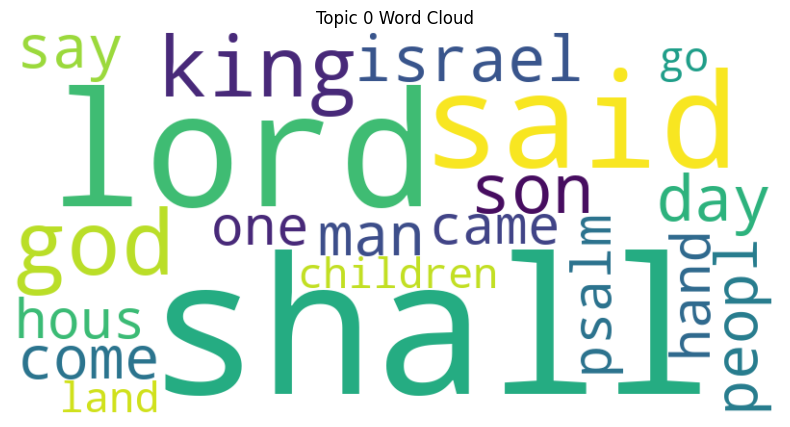

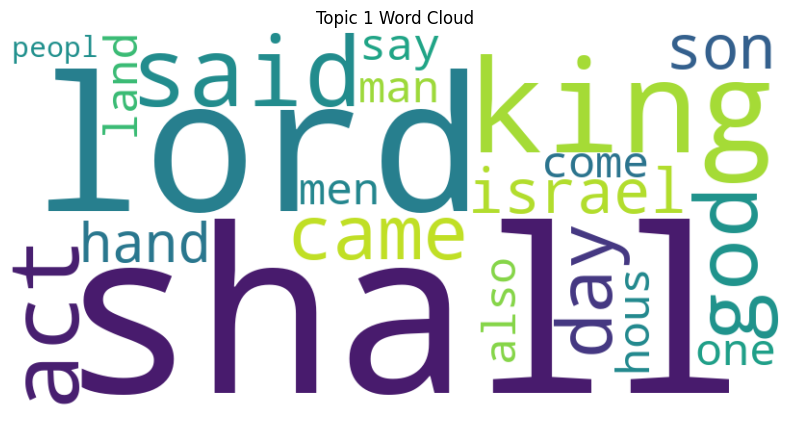

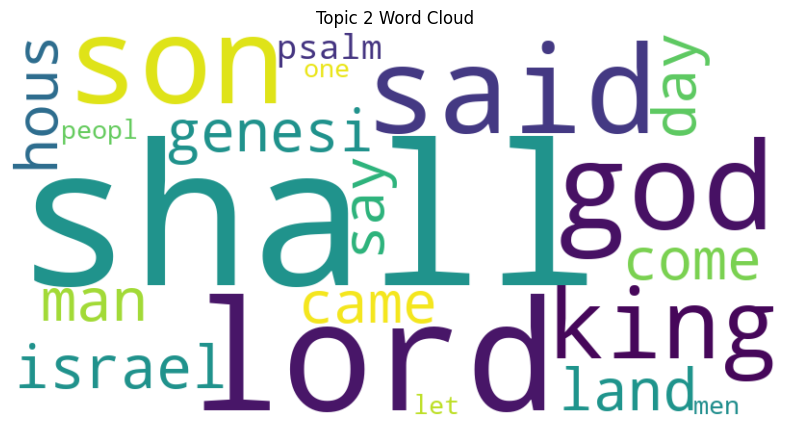

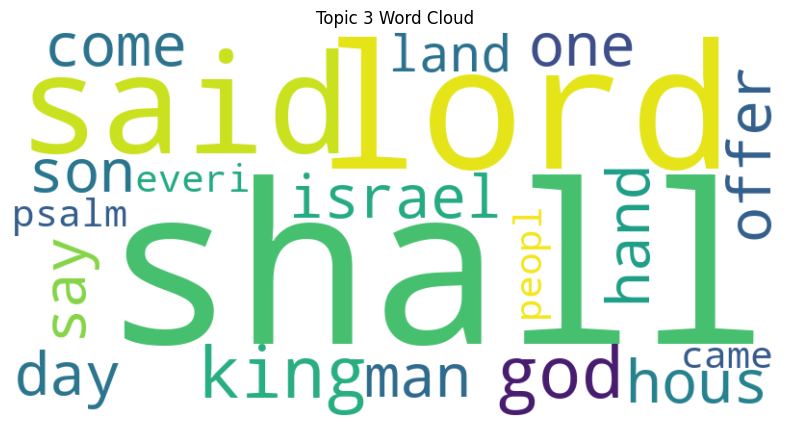

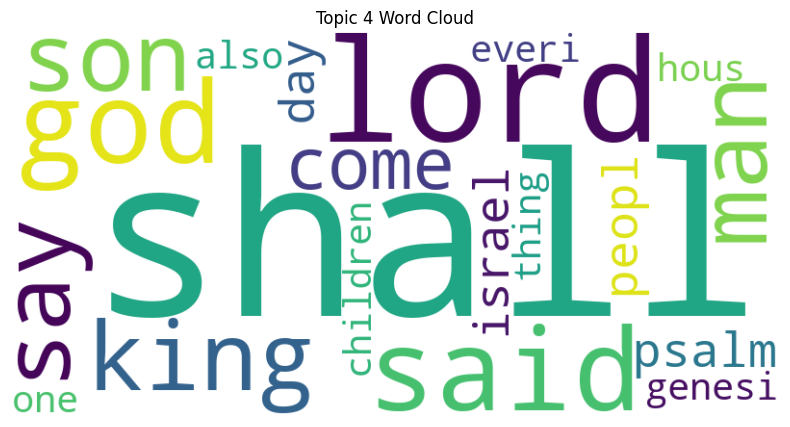

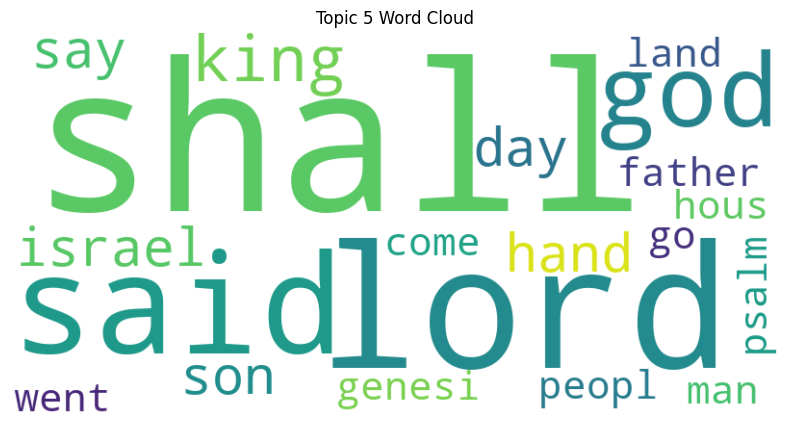

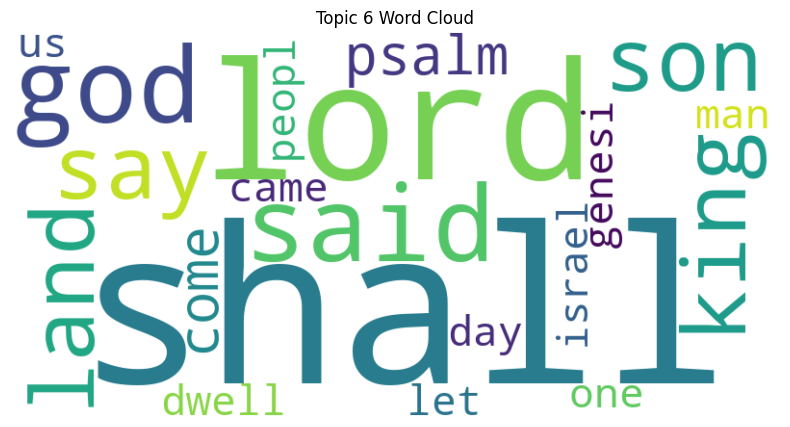

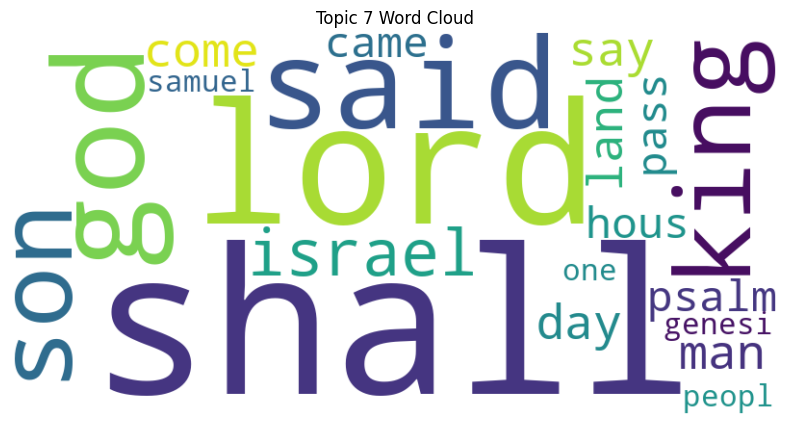

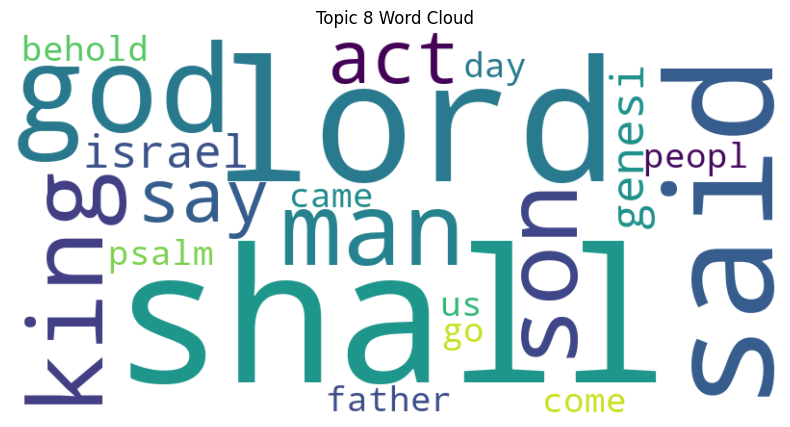

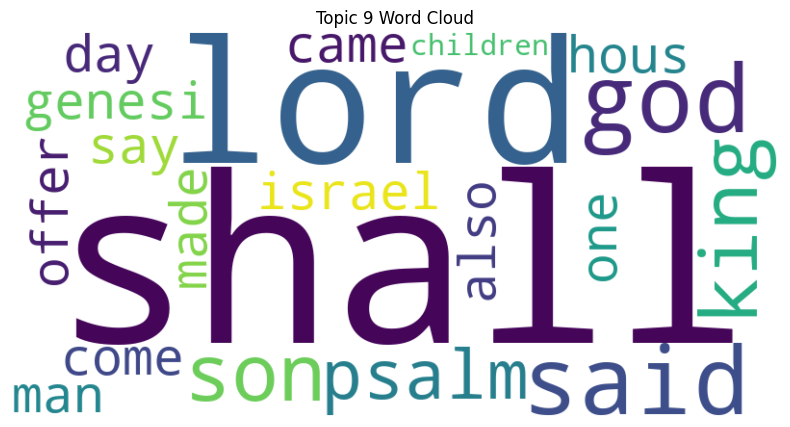

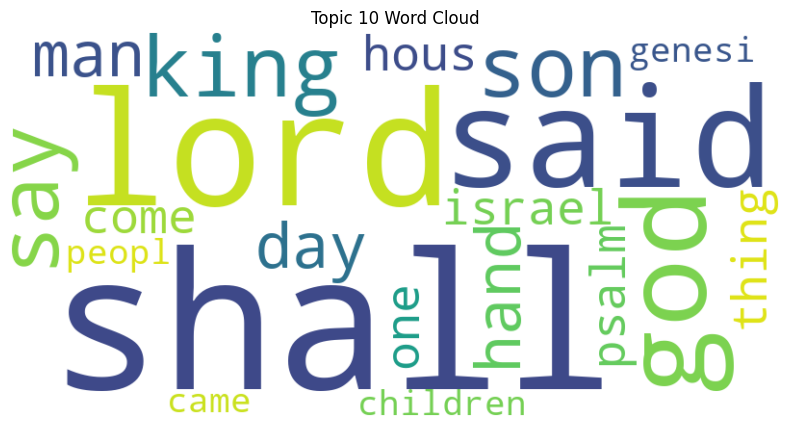

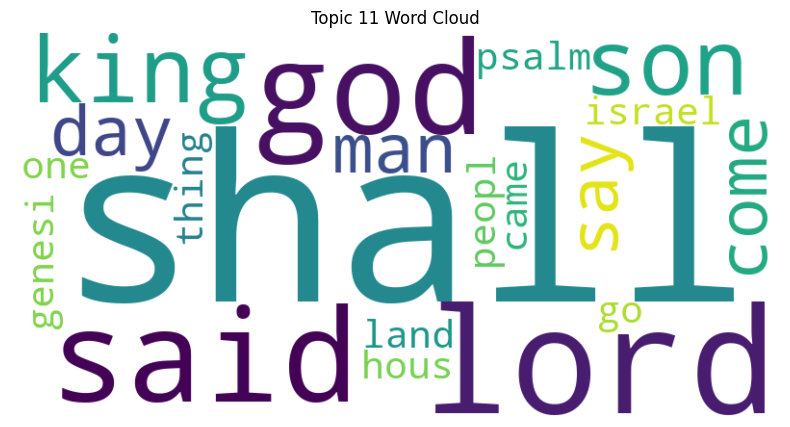

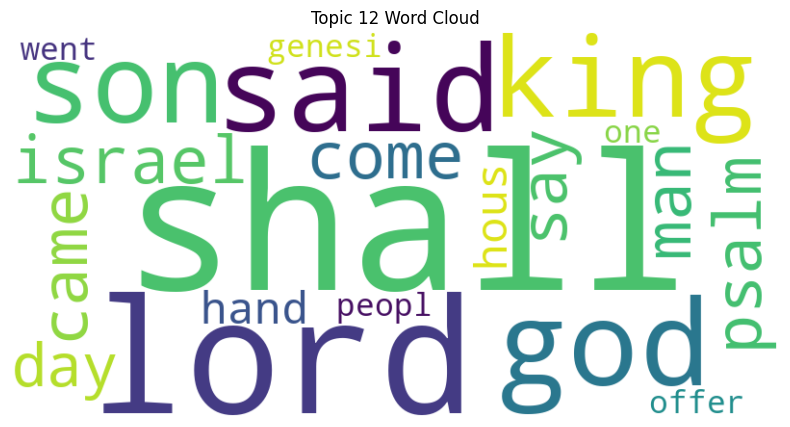

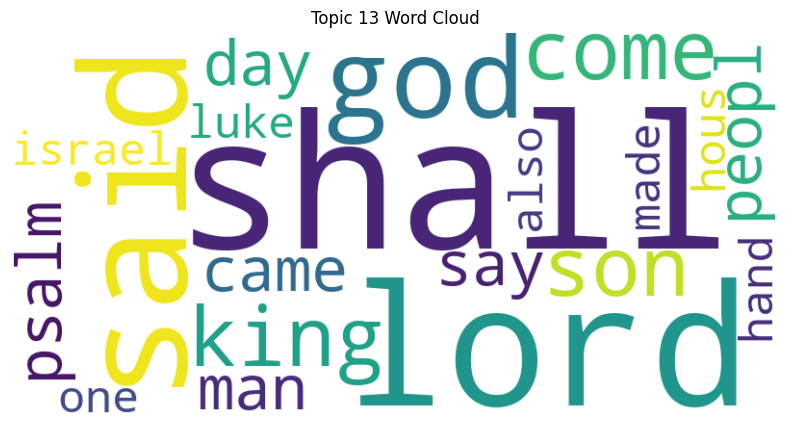

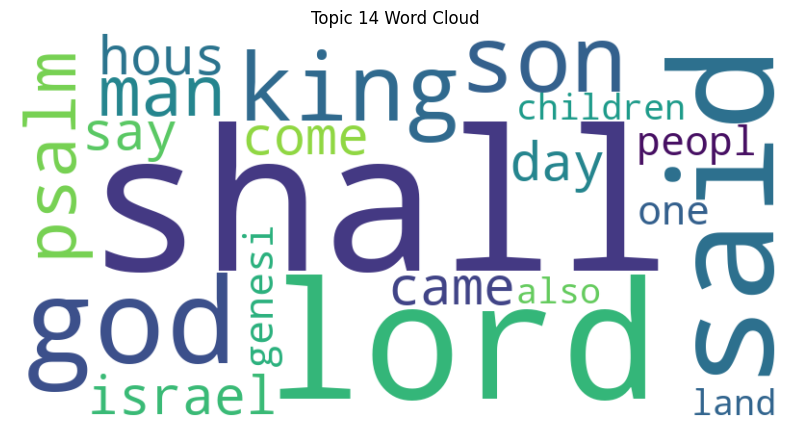

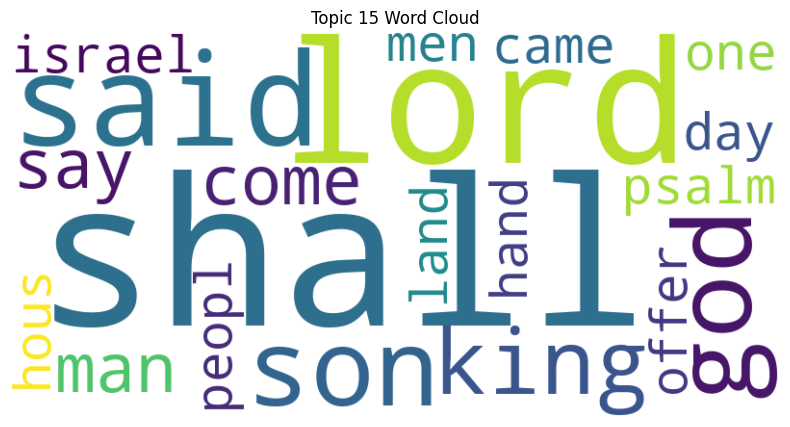

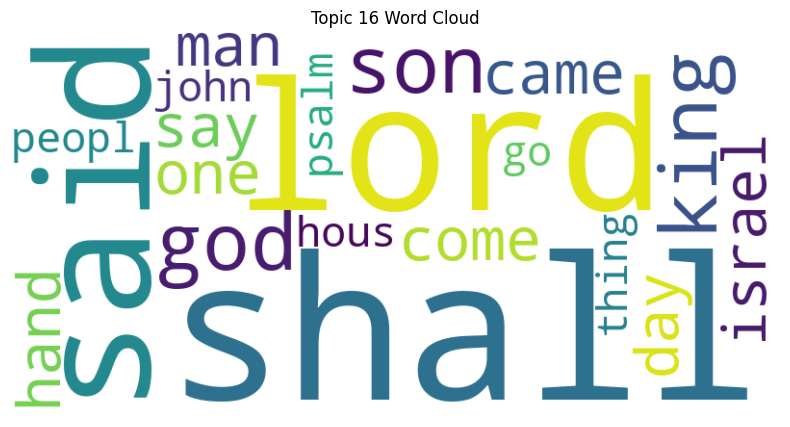

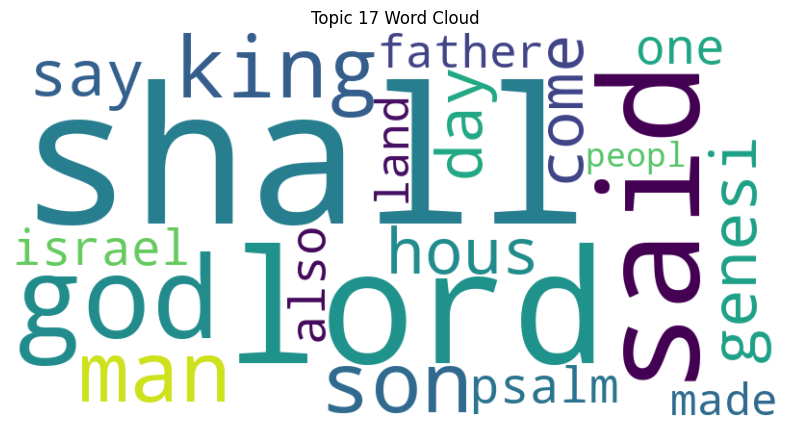

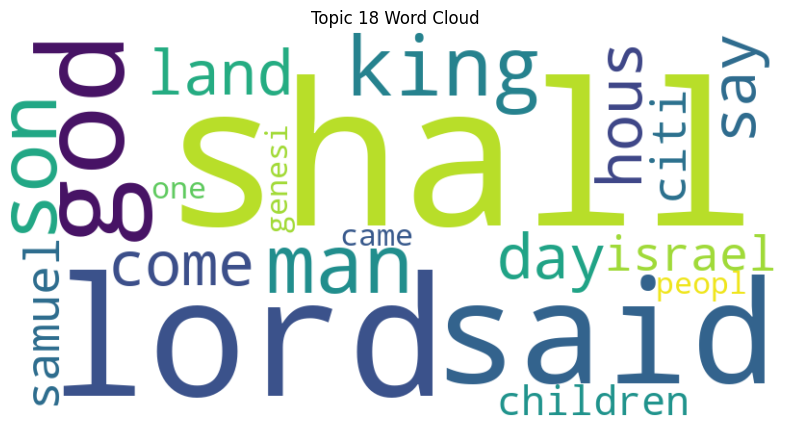

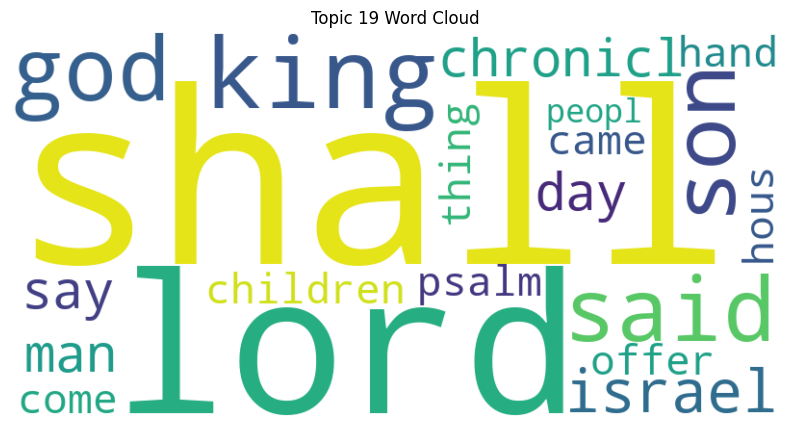

IndexError: index 22 is out of bounds for axis 0 with size 20

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Function to create word clouds for each topic
def create_wordclouds(hdp_model):
    topics = hdp_model.show_topics()
    for topic_id, topic in topics:
        word_freq = {word: float(freq) for freq, word in [pair.split('*') for pair in topic.split(' + ')]}
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id} Word Cloud')
        plt.axis('off')
        plt.show()

# Function to plot topic distribution across documents
def plot_topic_distribution(hdp_model, corpus):
    topic_dist = hdp_model[corpus]
    topics = [dict(topic) for topic in topic_dist]
    topic_matrix = np.zeros((len(corpus), len(hdp_model.show_topics())))

    for doc_id, doc_topics in enumerate(topics):
        for topic_id, topic_prob in doc_topics.items():
            topic_matrix[doc_id][topic_id] = topic_prob

    plt.figure(figsize=(12, 6))
    plt.imshow(topic_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Probability')
    plt.title('Topic Distribution across Documents')
    plt.xlabel('Topic')
    plt.ylabel('Document')
    plt.show()

# Assuming `hdp_model` and `corpus` are already defined

# Visualize word clouds for each topic
create_wordclouds(hdp_model)

# Visualize topic distribution across documents
plot_topic_distribution(hdp_model, corpus)


In [37]:
if response.status_code == 200:
    text = response.text

    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(preprocessed_text)

    # Apply SVD to the TF-IDF matrix
    n_components = 20 # Number of topics
    lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_topic_matrix = lsa_model.fit_transform(X)

    # Print the top words for each topic
    terms = vectorizer.get_feature_names_out()
    for i, topic in enumerate(lsa_model.components_):
        top_terms_idx = topic.argsort()[:-11:-1]
        top_terms = [terms[idx] for idx in top_terms_idx]
        print(f"Topic {i}: {' | '.join(top_terms)}")
else:
    print("Failed to fetch data from the URL:", response.status_code)

Topic 0: shall | father | us | thing | jeremiah | men | samuel | therefor | ezekiel | chronicl
Topic 1: lord | us | went | genesi | even | made | offer | john | job | number
Topic 2: said | made | jeremiah | offer | exodu | us | father | thing | peopl | therefor
Topic 3: god | went | samuel | offer | made | exodu | even | john | number | thing
Topic 4: king | genesi | samuel | father | men | let | chronicl | everi | went | came
Topic 5: son | father | us | genesi | samuel | chronicl | men | thing | let | came
Topic 6: man | jeremiah | israel | peopl | father | make | made | luke | psalm | thing
Topic 7: day | israel | say | go | us | also | word | land | come | ezekiel
Topic 8: say | behold | went | jeremiah | man | peopl | make | land | come | let
Topic 9: israel | say | went | psalm | samuel | made | chronicl | exodu | citi | father
Topic 10: psalm | come | go | behold | also | land | went | genesi | hand | word
Topic 11: come | father | made | therefor | thing | hous | chronicl | sa

In [41]:
if response.status_code == 200:
    text = response.text

    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(preprocessed_text)

    # Apply NMF to the TF-IDF matrix
    n_components = 10  # Number of topics
    nmf_model = NMF(n_components=n_components, random_state=42)
    nmf_topic_matrix = nmf_model.fit_transform(X)

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names_out()

    # Print topics, tokens, and corresponding vectors
    print("Topics, tokens, and corresponding vectors:")
    for i, topic_vector in enumerate(nmf_model.components_):
        print(f"Topic {i+1}:")
        for token, weight in zip(feature_names, topic_vector):
            print(f"{token}: {weight}")
        print()

else:
    print("Failed to fetch data from the URL:", response.status_code)


Topics, tokens, and corresponding vectors:
Topic 1:
1001: 1.5341899963992022e-191
1002: 1.5341899963992022e-191
1003: 1.5341899963992022e-191
1004: 1.5341899963992022e-191
1005: 1.5341899963992022e-191
101: 6.063769474816639e-120
1010: 1.6594035809914565e-120
1011: 6.063769474816639e-120
1012: 1.6594035809914565e-120
1013: 4.373671586383436e-121
1014: 4.373671586383436e-121
1015: 1.1077732115540044e-121
1016: 2.689687771410085e-122
1017: 2.689687771410085e-122
1018: 2.689687771410085e-122
1019: 5.781498873781912e-125
102: 6.063769474816639e-120
1020: 1.912165167291528e-126
1021: 3.147609262056477e-127
10210: 1.5341899963992022e-191
10211: 1.5341899963992022e-191
10212: 1.5341899963992022e-191
10213: 1.5341899963992022e-191
10214: 1.5341899963992022e-191
10215: 1.5341899963992022e-191
10216: 1.5341899963992022e-191
10217: 1.5341899963992022e-191
10218: 1.5341899963992022e-191
10219: 1.5341899963992022e-191
1022: 6.795103048053359e-129
10220: 1.5341899963992022e-191
10221: 1.534189996399

In [42]:
    # Print the topics
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {topic_idx + 1}:")
        top_idx = topic.argsort()[:-11:-1]
        top_terms = [feature_names[i] for i in top_idx]
        print(", ".join(top_terms))

Topic 1:
shall, psalm, come, hous, peopl, came, one, children, chronicl, land
Topic 2:
lord, come, hous, peopl, came, hand, also, land, thing, children
Topic 3:
said, psalm, come, hous, came, peopl, one, hand, also, children
Topic 4:
god, psalm, come, peopl, hous, came, one, hand, children, chronicl
Topic 5:
king, psalm, come, one, hous, peopl, came, hand, also, children
Topic 6:
son, psalm, come, one, hand, peopl, came, land, also, go
Topic 7:
man, hous, peopl, came, one, also, thing, men, genesi, jeremiah
Topic 8:
day, psalm, come, hand, chronicl, number, genesi, made, offer, isaiah
Topic 9:
say, hous, came, hand, chronicl, thing, go, genesi, father, us
Topic 10:
israel, psalm, come, one, hand, also, thing, men, land, samuel
